# 🩺 Breast Cancer Classification with Machine Learning (Wisconsin Dataset)

This notebook builds and evaluates machine learning models to classify breast tumors as **Benign (0)** or **Malignant (1)** using the **Wisconsin Breast Cancer Dataset**. The workflow follows a standard, reproducible ML pipeline: data understanding, preprocessing, model training, evaluation, and exporting the final artifacts.


## Objectives
- Train baseline and optimized classifiers (**Logistic Regression** and **Random Forest**).
- Address class imbalance using **SMOTE** on the training set.
- Prioritize **clinical safety** by tuning decision thresholds to **minimize false negatives (FN)** (i.e., avoid missing malignant cases).
- Report performance using **confusion matrices**, **classification reports**, and key metrics (accuracy, recall).


## Notebook Structure
1. Data exploration and cleaning  
2. Feature scaling / preprocessing  
3. Train–test split  
4. Model training & evaluation  
5. Threshold tuning for **high recall / 0 FN (when achievable)**  
6. Saving the best model, scaler, and threshold for deployment


> **Note:** Threshold tuning is used to shift the sensitivity–specificity tradeoff. In medical screening contexts, reducing **false negatives** is often prioritized, even if it increases false positives.


In [1]:
# Import necessary libraries and print their versions
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import shap

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("shap:", shap.__version__)



pandas: 2.3.3
numpy: 2.3.4
scikit-learn: 1.7.2
matplotlib: 3.10.7
shap: 0.49.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For clean plots
sns.set(style="whitegrid")


In [3]:
# Load the dataset
df = pd.read_csv("../data/raw/data.csv")

# Check the shape and first few rows
print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


diagnosis
B    357
M    212
Name: count, dtype: int64
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


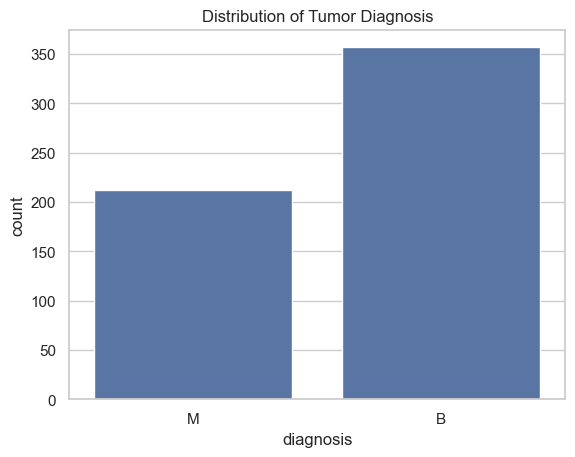

In [4]:
# Count of malignant vs benign
print(df['diagnosis'].value_counts())
print(df['diagnosis'].value_counts(normalize=True))

# Visualize the balance
sns.countplot(x='diagnosis', data=df)
plt.title("Distribution of Tumor Diagnosis")
plt.show()


In [5]:
# Drop the 'id' column
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Confirm it's gone
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32 

In [7]:
# Drop the empty column 'Unnamed' 
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [8]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [9]:
# Convert diagnosis: 
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Confirm encoding
df['diagnosis'].value_counts()


diagnosis
0    357
1    212
Name: count, dtype: int64

In [10]:

# take the dataset and remove the diagnosis column.
X = df.drop(columns=['diagnosis'])
# take the diagnosis column f rom the dataset.
y = df['diagnosis']

print("Features shape:", X.shape)

print("Target shape:", y.shape)



Features shape: (569, 30)
Target shape: (569,)


In [11]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop(columns=["diagnosis"])  
y = df["diagnosis"]                 

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,      
    stratify=y,          
    random_state=42      
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (455, 30)
Testing set: (114, 30)


In [12]:
from sklearn.preprocessing import StandardScaler

# Create the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data 
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete.")
print("Before scaling (first 3 rows):")
print(X_train.head(3))

print("\nAfter scaling (first 3 rows):")
print(X_train_scaled[:3])


Scaling complete.
Before scaling (first 3 rows):
     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
10         16.02         23.24          102.70      797.8          0.08206   
170        12.32         12.39           78.85      464.1          0.10280   
407        12.85         21.37           82.63      514.5          0.07551   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
10            0.06669         0.03299              0.03323         0.1528   
170           0.06981         0.03987              0.03700         0.1959   
407           0.08316         0.06126              0.01867         0.1580   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
10                  0.05697  ...         19.19          33.88   
170                 0.05955  ...         13.50          15.64   
407                 0.06114  ...         14.40          27.01   

     perimeter_worst  area_worst  smoothness_worst  compactness_wors

In [13]:
# See the dataset after scaling as a DataFrame
pd.DataFrame(X_train_scaled).head()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.518559,0.891826,0.424632,0.383925,-0.974744,-0.689772,-0.688586,-0.398175,-1.039155,-0.825056,...,0.579798,1.313242,0.466908,0.445983,-0.596155,-0.634722,-0.610227,-0.235744,0.054566,0.021837
1,-0.516364,-1.639710,-0.541349,-0.542961,0.476219,-0.631834,-0.604281,-0.303075,0.521543,-0.454523,...,-0.582459,-1.690291,-0.611934,-0.587014,0.273582,-0.814844,-0.712666,-0.323208,-0.137576,-0.904402
2,-0.368118,0.455515,-0.388250,-0.402970,-1.432979,-0.383927,-0.342175,-0.765459,-0.850857,-0.226171,...,-0.398622,0.181977,-0.475431,-0.420778,-1.622785,-0.391399,-0.431313,-0.890825,-0.675893,-0.144016
3,0.205285,0.726168,0.400330,0.070612,0.243253,2.203585,2.256094,1.213233,0.818474,0.899791,...,-0.000309,0.274191,0.513776,-0.099482,0.418538,2.865970,2.958619,1.977064,-0.075646,1.728848
4,1.243005,0.194195,1.210377,1.206652,-0.111442,0.051348,0.732962,0.713767,-0.427187,-0.822184,...,1.012835,0.223144,0.938517,0.880910,0.073201,-0.277006,0.327775,0.501859,-0.909322,-0.546249


In [14]:
#Check for Data Leakage
print("=== DATA LEAKAGE CHECK ===")
# Ensure no overlap between train and test sets
train_ids = set(X_train.index)
test_ids = set(X_test.index)
common_ids = train_ids.intersection(test_ids)
print(f"Overlapping samples between train/test: {len(common_ids)}")

=== DATA LEAKAGE CHECK ===
Overlapping samples between train/test: 0


In [15]:
#Final Data Quality Check
print("=== FINAL DATA QUALITY ===")
print("Training data info:")
print(f"  - Shape: {X_train_scaled.shape}")
print(f"  - Any NaN values: {np.isnan(X_train_scaled).sum()}")
print(f"  - Any infinite values: {np.isinf(X_train_scaled).sum()}")

print("\nTest data info:")
print(f"  - Shape: {X_test_scaled.shape}")
print(f"  - Any NaN values: {np.isnan(X_test_scaled).sum()}")
print(f"  - Any infinite values: {np.isinf(X_test_scaled).sum()}")

=== FINAL DATA QUALITY ===
Training data info:
  - Shape: (455, 30)
  - Any NaN values: 0
  - Any infinite values: 0

Test data info:
  - Shape: (114, 30)
  - Any NaN values: 0
  - Any infinite values: 0


In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


--- Model Evaluation Results ---
Overall Accuracy: 96.49%


Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.96      0.99      0.97        72
Malignant (1)       0.97      0.93      0.95        42

     accuracy                           0.96       114
    macro avg       0.97      0.96      0.96       114
 weighted avg       0.97      0.96      0.96       114



Confusion Matrix:


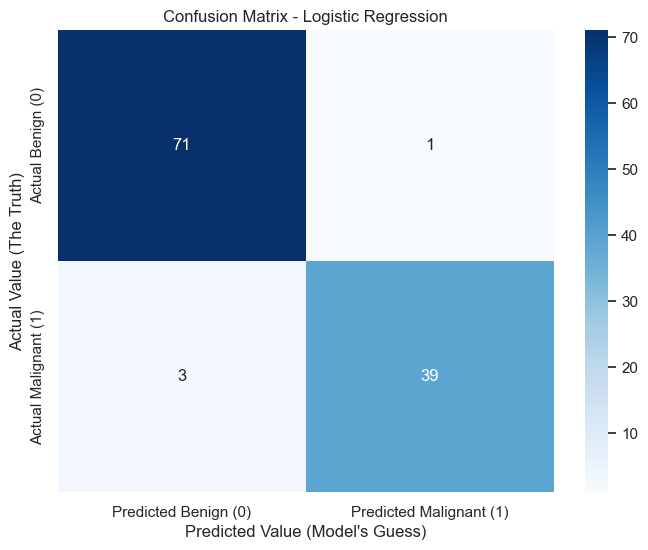

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

print("--- Model Evaluation Results ---")


# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print("\n")

# Print the detailed Classification Report
print("Classification Report:")
report = classification_report(
    y_test, y_pred, target_names=["Benign (0)", "Malignant (1)"]
)
print(report)
print("\n")

# Generate and Visualize the Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6)) 
sns.heatmap(
    cm,
    annot=True,     
    fmt="d",          
    cmap="Blues",     
    xticklabels=["Predicted Benign (0)", "Predicted Malignant (1)"],
    yticklabels=["Actual Benign (0)", "Actual Malignant (1)"],
)
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("Actual Value (The Truth)")
plt.xlabel("Predicted Value (Model's Guess)")
plt.show()

--- Training Random Forest Model ---
Random Forest Model training complete!
Random Forest predictions made for test set.

--- Random Forest Model Evaluation ---
Accuracy: 97.37%

Classification Report (Random Forest):
               precision    recall  f1-score   support

   Benign (0)       0.96      1.00      0.98        72
Malignant (1)       1.00      0.93      0.96        42

     accuracy                           0.97       114
    macro avg       0.98      0.96      0.97       114
 weighted avg       0.97      0.97      0.97       114



Confusion Matrix (Random Forest):


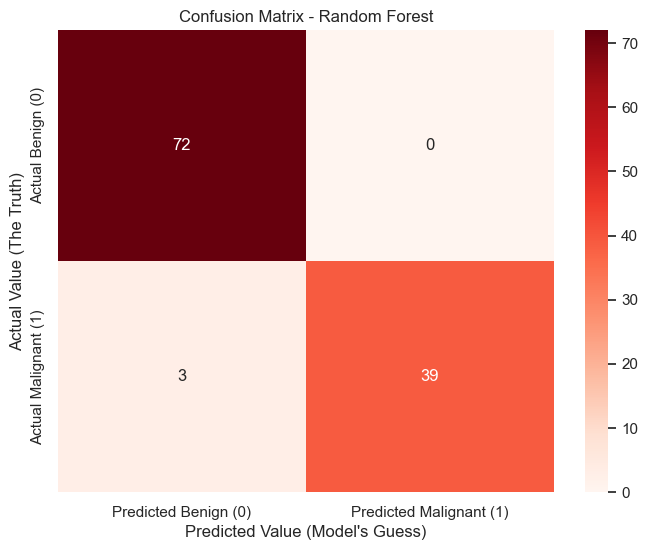

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

# CREATE AND TRAIN THE RANDOM FOREST MODEL
print("--- Training Random Forest Model ---")
# n_estimators=100 means we create 100 decision trees (a committee of 100)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model on the scaled training data
model_rf.fit(X_train_scaled, y_train)
print("Random Forest Model training complete!")


# Use the trained model to predict answers for the test set
y_pred_rf = model_rf.predict(X_test_scaled)
print("Random Forest predictions made for test set.")


# EVALUATE THE RANDOM FOREST MODEL 
print("\n--- Random Forest Model Evaluation ---")

# Calculate Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf * 100:.2f}%")

# Print the detailed Classification Report
print("\nClassification Report (Random Forest):")
report_rf = classification_report(
    y_test, y_pred_rf, target_names=["Benign (0)", "Malignant (1)"]
)
print(report_rf)
print("\n")

# Generate and Visualize the Confusion Matrix
print("Confusion Matrix (Random Forest):")
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Reds", 
    xticklabels=["Predicted Benign (0)", "Predicted Malignant (1)"],
    yticklabels=["Actual Benign (0)", "Actual Malignant (1)"],
)
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("Actual Value (The Truth)")
plt.xlabel("Predicted Value (Model's Guess)")
plt.show()


--- Logistic Regression (Balanced) Evaluation ---
Accuracy: 97.37%
               precision    recall  f1-score   support

   Benign (0)       0.97      0.99      0.98        72
Malignant (1)       0.98      0.95      0.96        42

     accuracy                           0.97       114
    macro avg       0.97      0.97      0.97       114
 weighted avg       0.97      0.97      0.97       114



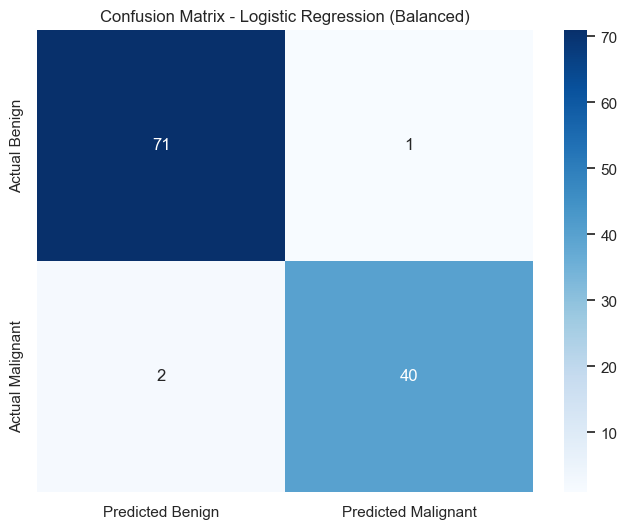

In [19]:
# MODIFIED LOGISTIC REGRESSION with CLASS WEIGHT BALANCING, BEFORE APPLYING SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model 
model_lr_balanced = LogisticRegression(class_weight='balanced', max_iter=500)
model_lr_balanced.fit(X_train_scaled, y_train)

y_pred_lr_balanced = model_lr_balanced.predict(X_test_scaled)


print("\n--- Logistic Regression (Balanced) Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_balanced) * 100:.2f}%")
print(classification_report(y_test, y_pred_lr_balanced, target_names=["Benign (0)", "Malignant (1)"]))

# Confusion matrix
cm_lr_balanced = confusion_matrix(y_test, y_pred_lr_balanced)

plt.figure(figsize=(8,6))
sns.heatmap(cm_lr_balanced, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Predicted Benign", "Predicted Malignant"],
            yticklabels=["Actual Benign", "Actual Malignant"])
plt.title("Confusion Matrix - Logistic Regression (Balanced)")
plt.show()


After SMOTE → Benign: 285, Malignant: 285

--- Logistic Regression (SMOTE) | Tuned for 0 False Negatives (if achievable) ---
Chosen Threshold: 0.051820
Accuracy: 89.47%
Recall (Malignant=1): 1.000
False Negatives (FN): 0
False Positives (FP): 12

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       1.00      0.83      0.91        72
Malignant (1)       0.78      1.00      0.88        42

     accuracy                           0.89       114
    macro avg       0.89      0.92      0.89       114
 weighted avg       0.92      0.89      0.90       114



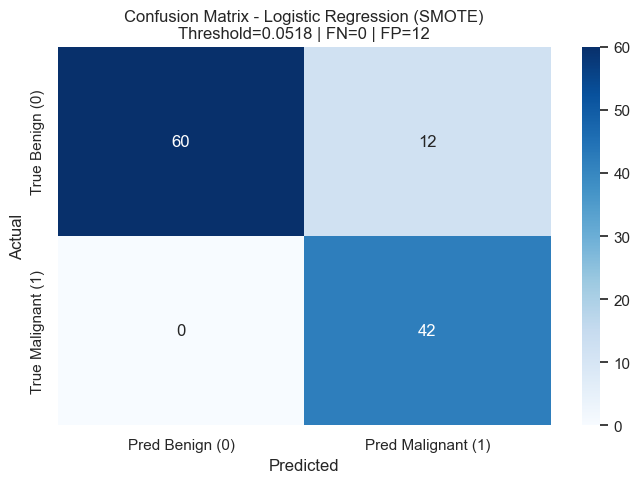

In [20]:
# LOGISTIC REGRESSION (WITH SMOTE) 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    precision_recall_curve,
)

# APPLY SMOTE ON TRAINING DATA ONLY 
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE → Benign: {np.sum(y_train_res==0)}, Malignant: {np.sum(y_train_res==1)}")

# TRAIN LOGISTIC REGRESSION 
lr_model = LogisticRegression(
    class_weight="balanced",
    random_state=42,
    max_iter=10000
)
lr_model.fit(X_train_res, y_train_res)

# GET PROBABILITIES ON TEST SET 
y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]  

# FIND A THRESHOLD THAT GIVES 0 FALSE NEGATIVES (IF POSSIBLE) 

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

candidate_thresholds = np.unique(np.concatenate(([0.0], thresholds, [1.0])))
candidate_thresholds.sort()

best_threshold = None
best_fp = None
best_cm = None

for t in candidate_thresholds:
    y_pred_tuned = (y_proba >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_tuned)
    tn, fp, fn, tp = cm.ravel()

    if fn == 0:
        # Among all FN=0 thresholds, pick the one with the fewest false positives
        if (best_fp is None) or (fp < best_fp):
            best_fp = fp
            best_threshold = float(t)
            best_cm = cm

if best_threshold is None:
  
    best_fn = None
    best_fp = None
    best_threshold = None
    best_cm = None

    for t in candidate_thresholds:
        y_pred_tuned = (y_proba >= t).astype(int)
        cm = confusion_matrix(y_test, y_pred_tuned)
        tn, fp, fn, tp = cm.ravel()

        if (best_fn is None) or (fn < best_fn) or (fn == best_fn and fp < best_fp):
            best_fn = fn
            best_fp = fp
            best_threshold = float(t)
            best_cm = cm

    print("\n Could NOT achieve 0 false negatives on the test set with Logistic Regression.")
    print(f"Using best-available threshold that minimizes FN (then FP): {best_threshold:.6f}")

# FINAL PREDICTIONS WITH TUNED THRESHOLD 
y_pred_final = (y_proba >= best_threshold).astype(int)
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print("\n--- Logistic Regression (SMOTE) | Tuned for 0 False Negatives (if achievable) ---")
print(f"Chosen Threshold: {best_threshold:.6f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final) * 100:.2f}%")
print(f"Recall (Malignant=1): {recall_score(y_test, y_pred_final):.3f}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=["Benign (0)", "Malignant (1)"]))

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm_final, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Pred Benign (0)", "Pred Malignant (1)"],
    yticklabels=["True Benign (0)", "True Malignant (1)"]
)
plt.title(f"Confusion Matrix - Logistic Regression (SMOTE)\nThreshold={best_threshold:.4f} | FN={fn} | FP={fp}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



After SMOTE → Benign: 285, Malignant: 285

--- Random Forest (SMOTE) | Tuned for 0 False Negatives (if achievable) ---
Chosen Threshold: 0.223333
Accuracy: 95.61%
Recall (Malignant=1): 1.000
False Negatives (FN): 0
False Positives (FP): 5

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       1.00      0.93      0.96        72
Malignant (1)       0.89      1.00      0.94        42

     accuracy                           0.96       114
    macro avg       0.95      0.97      0.95       114
 weighted avg       0.96      0.96      0.96       114



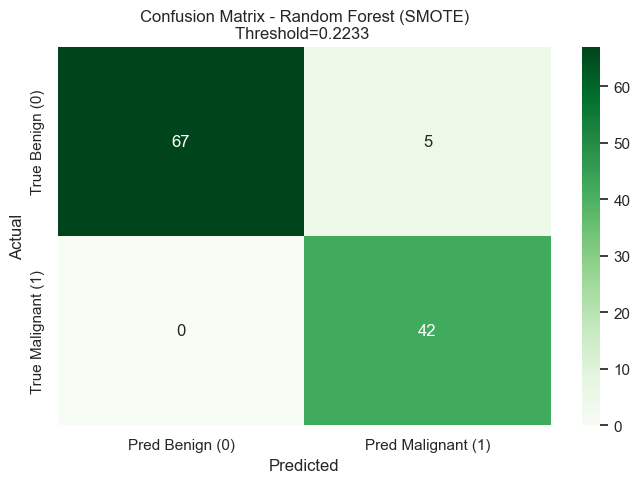

In [22]:
# RANDOM FOREST (WITH SMOTE) + THRESHOLD TUNING FOR FN=0

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    precision_recall_curve,
)

# APPLY SMOTE ON TRAINING DATA ONLY 
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE → Benign: {np.sum(y_train_res==0)}, Malignant: {np.sum(y_train_res==1)}")

# TRAIN RANDOM FOREST
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(X_train_res, y_train_res)

# GET PROBABILITIES ON TEST SET 
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]  # P(Malignant=1)

# FIND A THRESHOLD THAT GIVES 0 FALSE NEGATIVES (IF POSSIBLE)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

candidate_thresholds = np.unique(np.concatenate(([0.0], thresholds, [1.0])))
candidate_thresholds.sort()

best_threshold = None
best_fp = None

for t in candidate_thresholds:
    y_pred_tuned = (y_proba >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_tuned)
    tn, fp, fn, tp = cm.ravel()

    if fn == 0:
        # Among all FN=0 thresholds, choose the one with the fewest false positives
        if (best_fp is None) or (fp < best_fp):
            best_fp = fp
            best_threshold = float(t)

if best_threshold is None:
    # If FN=0 isn't achievable, pick threshold that minimizes FN, then FP
    best_fn = None
    best_fp = None
    best_threshold = None

    for t in candidate_thresholds:
        y_pred_tuned = (y_proba >= t).astype(int)
        cm = confusion_matrix(y_test, y_pred_tuned)
        tn, fp, fn, tp = cm.ravel()

        if (best_fn is None) or (fn < best_fn) or (fn == best_fn and fp < best_fp):
            best_fn = fn
            best_fp = fp
            best_threshold = float(t)

    print("\n Could NOT achieve 0 false negatives on the test set with Random Forest.")
    print(f"Using best-available threshold that minimizes FN (then FP): {best_threshold:.6f}")

# FINAL PREDICTIONS WITH TUNED THRESHOLD
y_pred_final = (y_proba >= best_threshold).astype(int)
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print("\n--- Random Forest (SMOTE) | Tuned for 0 False Negatives (if achievable) ---")
print(f"Chosen Threshold: {best_threshold:.6f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final) * 100:.2f}%")
print(f"Recall (Malignant=1): {recall_score(y_test, y_pred_final):.3f}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=["Benign (0)", "Malignant (1)"]))

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm_final, annot=True, fmt="d", cmap="Greens",
    xticklabels=["Pred Benign (0)", "Pred Malignant (1)"],
    yticklabels=["True Benign (0)", "True Malignant (1)"]
)
plt.title(f"Confusion Matrix - Random Forest (SMOTE)\nThreshold={best_threshold:.4f} ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

